## Challenge01 - Graduate Admission Prediction

Your task is to predict Graduate Admissions for students. The application being considered is for admission to a Master’s program.

### Nomenklatur

```
| ID                  |  indeks penomoran mahasiswa
| GRE                 |  Nilai tes GRE (maks 340)
| TOEFL               |  Nilai tes TOEFL (maks 120)
| University_Rating   |  Rating universitas (maks 5)
| SOP                 |  Kualitas Statement of Purpose (maks 5)
| LOR                 |  Kualitas Surat Rekomendasi (maks 5)
| CGPA                |  IPK (maks 10)
| Research            |  0: tidak berpengalaman 
|                     |  1: berpengalaman dalam riset
| Chance_of_Admit     |  Kesempatan diterima (0 sampai 1)
```
Catatan: Nilai tes dan IPK masih dalam format lama


### Tasks
<div class="alert alert-block alert-danger">
    🚫 <b> Restriction:</b> Please refrain from using <b>ChatGPT</b> to complete this exercise, as doing so may hinder your learning experience.
</div>
Saya sudah mempersiapkan 2 file, yaitu **train.csv** dan **test.csv**
- **train.csv** berisi data yang telah dilabeli (ada `X` dan `y`)
- **test.csv** tidak memiliki label (hanya `X`)

Tugas kamu adalah untuk memprediksi `Chance_of_Admit` dari seluruh mahasiswa di **test.csv** seperti gambar di bawah ini
![Instruksi](./assets/instruksi.png)


### Submission

Hasil prediksi harus disusun dalam format sebagai berikut
```
|  ID | Chance_of_Admit |
------------------------
| 362 |   <prediksi>    |
|  74 |   <prediksi>    |
| 375 |   <prediksi>    |
| ... |   __________    |
| ... |   __________    |
```
dan di save dalam format **.csv** dengan nama file **nama__versi.csv**. Misalnya `jennie__v1.csv`.

Apabila kamu kesulitan untuk membuat format tersebut, silahkan gunakan snippet berikut


```python
def submit(model, filename="jennie__v1.csv"):
    df_submit = pd.read_csv("data/test.csv", index_col="ID")
    df_submit['Chance_of_Admit'] = model.predict(df_submit)
    df_submit[['Chance_of_Admit']].to_csv(filename, index_label='ID')
```

Kirimkan **nama__versi.csv** ke saya, via email/chat/etc.\
**Public leaderboard** akan saya update minimal 1x/hari, maklum masih hitung manual.\
**Private leaderboard** akan saya umumkan di Meet 05. Hasil tertinggi di private board akan mendapatkan sesuatu yg menarik dari saya.


### Penilaian
- Hanya **submission terakhir** yang akan digunakan untuk penilaian
- Model akan dinilai berdasarkan **R-squared**
- **Public score** hanyalah score terhadap **50% dari test.csv**
- **Private score** menggunakan **semua test.csv**

### Hint
- Lakukan submission berkali-kali dan manfaatkan hasil dari public score sebagai insight
- Jangan lupa versioning agar kamu bisa submit model terbaik di akhir
- Start with simple model. Manfaatkan workflow 4 fasa sebelum melakukan feature engineering yang lebih kompleks.
- Kamu bebas memilih besarnya test size, cross-validation fold, bahkan random state
- Kamu bebas memilih preprocessor yang akan digunakan untuk masing-masing fitur
- Kamu bebas memilih algoritma machine learning yang ingin dipakai
- Kamu bebas memilih teknik parameter search yang ingin dipakai
- Kalau ada waktu lebih, coba lakukan evaluasi seperti residual plot

In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

### Import Data 

In [22]:
df = pd.read_csv("data/train.csv")
display(df.head())

,ID,GRE,TOEFL,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,250,321,111,3,3.5,4.0,8.83,1,0.77
1,434,316,111,4,4.0,5.0,8.54,0,0.71
2,20,303,102,3,3.5,3.0,8.50,0,0.62
3,323,314,107,2,2.5,4.0,8.27,0,0.72
4,333,308,106,3,3.5,2.5,8.21,1,0.75


In [12]:

X = df.drop(columns="Chance_of_Admit") ## all columns but target
y = df.Chance_of_Admit ## target data

# X_train = df.drop(columns="Chance_of_Admit") ## all columns but target
# y_train = df.Chance_of_Admit ## target data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train.shape, y_train.shape

((320, 8), (320,))

In [13]:
from jcopml.tuning import grid_search_params as gsp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from jcopml.tuning import grid_search_params as rsp

preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['ID', 'GRE', 'TOEFL', 'University_Rating', 'SOP', 'LOR', 'CGPA']),
    ("categoric", cat_pipe(encoder='onehot'), ['Research'])
])

# pipeline = Pipeline([
#     ("prep", preprocessor),
#     ("algo", LinearRegression())
# ])

# model = GridSearchCV(pipeline, gsp.linreg_params, cv=2, n_jobs=-1, verbose=1)
# model.fit(X_train, y_train)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_)
print(model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__subsample': 0.4, 'algo__reg_lambda': 10, 'algo__reg_alpha': 0.1, 'algo__n_estimators': 200, 'algo__max_depth': 10, 'algo__learning_rate': 1, 'algo__gamma': 1, 'algo__colsample_bytree': 0.6}
0.5028424608307078 0.5031460765243913
0.4856379053083456


In [14]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

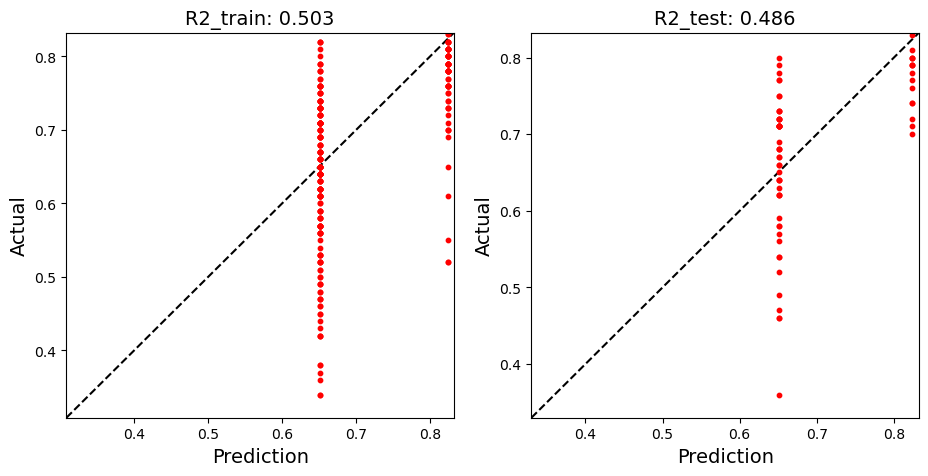

In [15]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

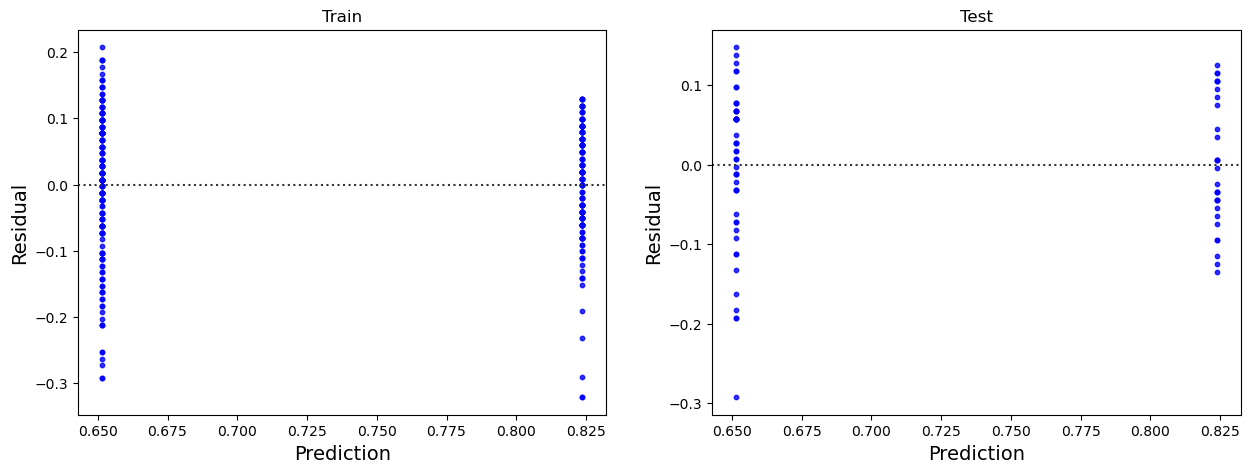

In [16]:
plot_residual(X_train, y_train, X_test, y_test, model, lowess=False)

In [17]:
def submit(model, filename="yayat__v8.csv"):
    df_submit = pd.read_csv("data/test.csv")
    df_submit['Chance_of_Admit'] = model.predict(df_submit)
    df_submit[['Chance_of_Admit']].to_csv(filename)

In [18]:
submit(model)

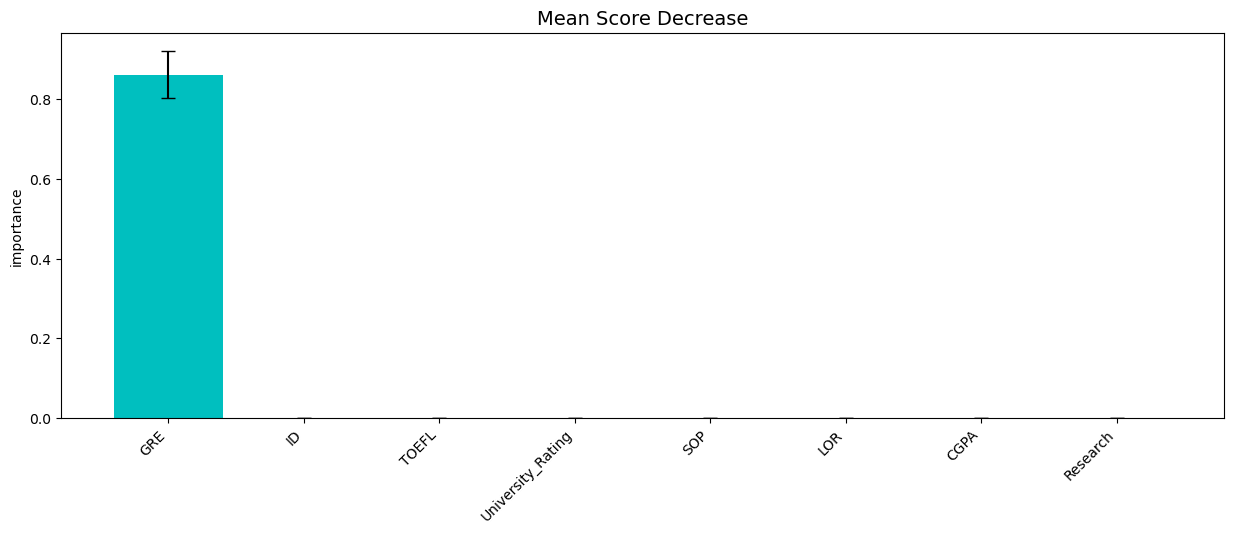

In [19]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [20]:
from jcopml.tuning import grid_search_params as gsp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from jcopml.tuning import grid_search_params as rsp

preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['GRE']),
    ("categoric", cat_pipe(encoder='onehot'), [])
])

# pipeline = Pipeline([
#     ("prep", preprocessor),
#     ("algo", LinearRegression())
# ])

# model = GridSearchCV(pipeline, gsp.linreg_params, cv=2, n_jobs=-1, verbose=1)
# model.fit(X_train, y_train)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_)
print(model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__subsample': 0.4, 'algo__reg_lambda': 10, 'algo__reg_alpha': 0.1, 'algo__n_estimators': 200, 'algo__max_depth': 10, 'algo__learning_rate': 1, 'algo__gamma': 1, 'algo__colsample_bytree': 0.6}
0.5028424608307078 0.48999932503476806
0.4856379053083456
